# Ablation Study Result

Section 5.D in manuscript (Table 2-a, Table 3, Table 4, Fig. 3b, Fig. 3c)

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import os
import math
import platform
import shap
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

from matplotlib import font_manager, rc
ttf = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=ttf).get_name()
rc('font', family=font_name)
rc('axes', unicode_minus=False)

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Activation,Dropout
from tensorflow.keras import backend as K,losses
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K,losses

from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.97
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))  

### Load dataset

In [2]:
ExternalInp = np.load('D:\Dropbox\HPI\ProcessedData/ExtInp.npy', allow_pickle=True)
ExternalOut = np.load('D:\Dropbox\HPI\ProcessedData/ExtOut.npy', allow_pickle=True)

In [3]:
ValInp = np.load('D:\Dropbox\HPI\ProcessedData/IntValInp.npy', allow_pickle=True)
ValOut = np.load('D:\Dropbox\HPI\ProcessedData/IntValOut.npy', allow_pickle=True)

## Ablation Model 1

In [26]:
def FilterGen (FC):

    # Sinc function
    X = (2 * FC * (RanVar[None] - (N - 1) / 2))
    X = tf.where(X == 0, K.epsilon(), X)
    SinF = tf.sin(np.pi*X)/(np.pi*X)

    # Black man window
    BW = 0.42 - 0.5 * tf.math.cos(2 * np.pi * RanVar / (N - 1)) +  0.08 * tf.math.cos(4 * np.pi * RanVar / (N - 1))

    SinFBW = SinF * BW
    LP = SinFBW /  K.sum(SinFBW, axis=-1, keepdims=True)
    HP = -LP
    TmpZeros = tf.zeros((N - 1) // 2)
    TmpOnes = tf.ones(1)
    AddOne = tf.concat([TmpZeros,TmpOnes,TmpZeros], axis=0)
    HP += AddOne

    return LP, HP

def DownSampling (ToDown):
    if ToDown.shape[1] % 2 != 0: 
        ToDown = tf.concat([K.mean(ToDown[:, :2], axis=1, keepdims=True), ToDown[:, 2:]], axis=1)
    return K.mean(tf.signal.frame(ToDown[:,:,0], 2,2, axis=1), axis=-1)   


class DoGenVec(tf.keras.layers.Layer):
    
    def __init__(self, OutDimes):
        super(DoGenVec, self).__init__()
        self.Shapelet1Size = OutDimes[0]
        self.WinSize = OutDimes[1]
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'Shapelet1Size': self.Shapelet1Size,
            'WinSize': self.WinSize})
        return config
    
    def build(self, input_shape):
        self.GenVec = self.add_weight("GenVec", shape=[self.Shapelet1Size, self.WinSize], initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
    
    def call(self, input):
        input = K.sum(input) * 0 + 1 # Weight matrix만 return 해주기 위해 이전 input tensor 값을 스칼라 1로 변경 후 weight matrix와 곱함, weight matrix만 return 할 경우 극심한 warning message...
        return (input*self.GenVec)

In [31]:
Shapelet1Size = 30
PaddSideForSim = 12
FrameSize = 50
AttSize = 5

b = 0.08 # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
N = int(np.ceil((4 / b)))
if not N % 2:  # Make sure that N is odd.
    N += 1  
RanVar = tf.constant(np.arange(N), dtype=tf.float32)
PaddSideForConv = (N-1)//2

InputVec = Input(shape=(9000), name='Input')

### A. Discrete wavelet transform layers ###

# DWT 1st level
FC1 = Conv1D(filters= 1,kernel_size= 20, strides=20//5, activation='softplus')(InputVec[:,:,None])
FC1 = MaxPooling1D(pool_size=20,strides=20//5)(FC1)
FC1 = Conv1D(filters= 1,kernel_size= 10, strides=10//2)(FC1)
FC1 = MaxPooling1D(pool_size=10,strides=10//2)(FC1)[:,:,0]
FC1 = Dense(10, activation='relu')(FC1)
FC1 = Dense(1, activation='sigmoid')(FC1)
FC1 = FC1*(0.5-K.epsilon())+K.epsilon()
LP1, HP1 =  FilterGen (FC1)

InputVecPad = tf.signal.frame(InputVec, N, 1)
LP1_res = K.sum(InputVecPad * LP1[:,None,:], axis=-1, keepdims=True)
LP1_Down = DownSampling(LP1_res)


# DWT 2nd level
FC2 = Conv1D(filters= 1,kernel_size= 20, strides=20//5, activation='softplus')(LP1_Down[:,:,None])
FC2 = MaxPooling1D(pool_size=20,strides=20//5)(FC2)
FC2 = Conv1D(filters= 1,kernel_size= 10, strides=10//2)(FC2)
FC2 = MaxPooling1D(pool_size=10,strides=10//2)(FC2)[:,:,0]
FC2 = Dense(10, activation='relu')(FC2)
FC2 = Dense(1, activation='sigmoid')(FC2)
FC2 = FC2*(0.5-K.epsilon())+K.epsilon()
LP2, HP2 =  FilterGen (FC2)

LP1_DownPad = tf.signal.frame(LP1_Down, N, 1)
LP2_res = K.sum(LP1_DownPad * LP2[:,None,:], axis=-1, keepdims=True)
LP2_Down = DownSampling(LP2_res)


# DWT 3rd level
FC3 = Conv1D(filters= 1,kernel_size= 10, strides=10//4, activation='softplus')(LP2_Down[:,:,None])
FC3 = MaxPooling1D(pool_size=10,strides=10//4)(FC3)
FC3 = Conv1D(filters= 1,kernel_size= 10, strides=10//2)(FC3)
FC3 = MaxPooling1D(pool_size=10,strides=10//2)(FC3)[:,:,0]
FC3 = Dense(10, activation='relu')(FC3)
FC3 = Dense(1, activation='sigmoid')(FC3)
FC3 = FC3*(0.5-K.epsilon())+K.epsilon()
LP3, HP3 =  FilterGen (FC3)

LP2_DownPad = tf.signal.frame(LP2_Down, N, 1)
LP3_res = K.sum(LP2_DownPad * LP3[:,None,:], axis=-1, keepdims=True)
LP3_Down = DownSampling(LP3_res)


# DWT 4th level
FC4 = Conv1D(filters= 1,kernel_size= 10, strides=10//2, activation='softplus')(LP3_Down[:,:,None])
FC4 = MaxPooling1D(pool_size=10,strides=10//2)(FC4)
FC4 = Conv1D(filters= 1,kernel_size= 5, strides=5//2)(FC4)
FC4 = MaxPooling1D(pool_size=5,strides=5//2)(FC4)[:,:,0]
FC4 = Dense(10, activation='relu')(FC4)
FC4 = Dense(1, activation='sigmoid')(FC4)
FC4 = FC4*(0.5-K.epsilon())+K.epsilon()
LP4, HP4 =  FilterGen (FC4)

LP3_DownPad = tf.signal.frame(LP3_Down, N, 1)
LP4_res = K.sum(LP3_DownPad * LP4[:,None,:], axis=-1, keepdims=True)
LP4_Down = DownSampling(LP4_res)


# DWT 5th level
FC5 = Conv1D(filters= 1,kernel_size= 10, strides=10//2, activation='softplus')(LP4_Down[:,:,None])
FC5 = MaxPooling1D(pool_size=10,strides=10//2)(FC5)
FC5 = Conv1D(filters= 1,kernel_size= 5, strides=5//2)(FC5)
FC5 = MaxPooling1D(pool_size=5,strides=5//2)(FC5)[:,:,0]
FC5 = Dense(10, activation='relu')(FC5)
FC5 = Dense(1, activation='sigmoid')(FC5)
FC5 = FC5*(0.5-K.epsilon())+K.epsilon()
LP5, HP5 =  FilterGen (FC5)

LP4_DownPad = tf.signal.frame(LP4_Down, N, 1)
LP5_res = K.sum(LP4_DownPad * LP5[:,None,:], axis=-1, keepdims=True)
LP5_Down = DownSampling(LP5_res)

LP5_FeatDim = tf.signal.frame(LP5_Down, FrameSize, 1)


### B. Local shape similarity layers ###
GenVecLayer = DoGenVec([Shapelet1Size, FrameSize])
GenVec = Activation('sigmoid')(GenVecLayer(InputVec)) 

LP5_X_sqare = K.sum(K.square(LP5_FeatDim), axis=2,keepdims=True)
LP5_Y_sqare = K.sum(K.square(GenVec[:]), axis=1)[None,None]
LP5_XY = tf.matmul(LP5_FeatDim, GenVec[:], transpose_b=True)
LP5_Dist = (LP5_X_sqare + LP5_Y_sqare - 2*LP5_XY) 
LP5_Dist_sqrt = K.sqrt(LP5_Dist+K.epsilon())

### D. Regresion layers ###
Features_W = K.exp(-LP5_Dist_sqrt) 
Features = K.max(Features_W, axis=1) 
BinOut = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=0),name='BinOut')(Dropout(0.0)(Features))

BinModel = Model(InputVec, BinOut)

### Add cluster loss ###
ClLoss = K.mean(K.min(LP5_Dist, axis=1) )
BinModel.add_loss(ClLoss)
BinModel.add_metric(ClLoss, name='ClLoss')

lrate = 0.0005
decay = 1e-6
adam = tf.keras.optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=decay)
BinModel.compile(loss='binary_crossentropy', optimizer='adam',  metrics={'BinOut':['binary_crossentropy','AUC']}, ) #'binary_crossentropy'
BinModel.load_weights('Ablation1_413_0.37552_0.90841_0.24394_0.40831_0.89221_0.24933.hdf5')

### Table 2.a Prediction Performance

In [32]:
# Internal Validation AUC
from sklearn import metrics
pred = Model(InputVec, BinOut).predict(ValInp[:, 9000:], batch_size=1000, verbose=1)
fprIV, tprIV, thresholdsIV = metrics.roc_curve(ValOut[:], pred, pos_label=1)
metrics.auc(fprIV, tprIV)

60/60 [==============================] - 7s 52ms/step


0.9086751040576775

In [33]:
# External Validation AUC
from sklearn import metrics
pred = Model(InputVec, BinOut).predict(ExternalInp[:, 9000:], batch_size=1000, verbose=1)
fprEV, tprEV, thresholdsEV = metrics.roc_curve(ExternalOut[:], pred, pos_label=1)
metrics.auc(fprEV, tprEV)

60/60 [==============================] - 4s 50ms/step


0.8922692240341823

### Table 3 Coefficient Values from the Logit Layer 

Coefficients by gradient descent method

In [34]:
# extract logistic regression layer from model
Coef = BinModel.get_layer('BinOut').get_weights()[0]

Coefficients by Newton-Raphson method

In [35]:
# extract similarity values (x) for logistic regression
tmpMo = Model(InputVec,Features)
FeaturesPred = tmpMo.predict(ValInp[:, 9000:], batch_size=1000, verbose=1) 

60/60 [==============================] - 4s 58ms/step


[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[4, 29]
Num of Features to Keep :  2


<AxesSubplot:>

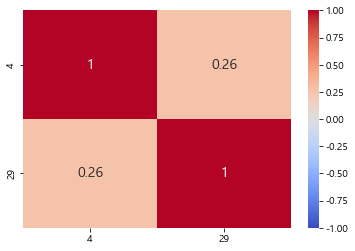

In [36]:
### Filter by correlation ###

# Create correlation matrix
FeaturesPred = pd.DataFrame(FeaturesPred)
FeaturesPred['Hypo'] = ValOut
FeaturesCorr = FeaturesPred.corr()
corr_matrix = FeaturesCorr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_keep = [x for x in list(range(Shapelet1Size)) if x not in to_drop]

print(to_drop) 
print(to_keep) 
print('Num of Features to Keep : ', len(to_keep))
# Drop highly correlated features 
FeaturesPred_bycorr = corr_matrix[to_keep]

sns.heatmap(data = FeaturesCorr.loc[to_keep,to_keep], annot=True, annot_kws={"fontsize":14}, cmap='coolwarm', vmin=-1, vmax=1)

In [37]:
### Logistic regression: X = similarity vlaues, y = hypotension label ###

# DataSet Preparation
X = np.array(FeaturesPred.copy().iloc[:,list(FeaturesPred_bycorr.columns)])
X = sm.add_constant(X)
y = ValOut.copy()

# Fit Logit Model
LogitModel = sm.Logit(y, X)
result = LogitModel.fit()

Optimization terminated successfully.
         Current function value: 0.387850
         Iterations 6


In [38]:
### Filter by p-value ###

StatResult = pd.DataFrame(np.array([np.array(FeaturesPred_bycorr.columns), 
                                    np.round(result.params[1:], 4), 
                                    np.round(result.pvalues, 4)[1:]]).transpose(), 
                          columns=['Feature_ID', 'NR-method', 'pVal'])
StatResult.insert(1, 'GD-method', np.round(Coef[to_keep],4))
pValSig = StatResult.sort_values('pVal').query('pVal <= 0.1')
pValShapIDX = list(pValSig.Feature_ID.astype('int32').values)
pValSig

,Feature_ID,GD-method,NR-method,pVal
0,4,10.6953,10.0754,0.0
1,29,1.3649,-4.0752,0.0


### Table 4 Confusion Matrix of Maximum Similarity with the Representative Shapes

In [39]:
# extract GenVec layer to obtain representative ABP trends
tmpMo = Model(InputVec, GenVec)
GenVecp = tmpMo.predict(ValInp[0:1, 9000:])
GenVecp.shape

(30, 50)

In [40]:
# extract LP5_Dist_sqrt to compute similarity with representative ABP trends
tmpMo = Model(InputVec,LP5_Dist_sqrt)
LP5Dist = tmpMo.predict(ValInp[:, 9000:], batch_size=1000, verbose=1)  # computing distance
LP5Sim = K.exp(-LP5Dist)  # computing similarity
LP5Sim.shape

60/60 [==============================] - 5s 66ms/step


TensorShape([60000, 183, 30])

In [41]:
### Count the number of samples with maximum similarity to each shape ###

FrequentShap = []
FrequentShapH = [] # Actual hypotension
FrequentShapNH = [] # Actual non-hypotension

for i in range(LP5Sim.shape[0]):
    pValShap = np.array([LP5Sim[i][:,shapIDX] for shapIDX in pValShapIDX])
    FrequentShap.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
    if ValOut[i] == 1:
        FrequentShapH.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
    else:
        FrequentShapNH.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
             
FrequentShapH = np.bincount(np.array(FrequentShapH), minlength=len(pValShapIDX))
FreqGenVecH = GenVecp[pValShapIDX]
FrequentShapNH = np.bincount(np.array(FrequentShapNH), minlength=len(pValShapIDX))
FreqGenVecNH = GenVecp[pValShapIDX]

print("Number of max similiarity with each shape for hypotension samples: ", FrequentShapH)
print("Number of max similiarity with each shape for non-hypotension samples: ", FrequentShapNH)

FreqCounts = pd.DataFrame([FrequentShapH, FrequentShapNH], index=['Hypo', 'NonHypo'], columns=pValShapIDX)
FreqCounts

Number of max similiarity with each shape for hypotension samples:  [19620  7569]
Number of max similiarity with each shape for non-hypotension samples:  [ 2506 30305]


,4,29
Hypo,19620,7569
NonHypo,2506,30305


In [42]:
### Compute confusion matrix for each shape ###

# get predicted values
ValPred = Model(InputVec, BinOut).predict(ValInp[:, 9000:], batch_size=1000, verbose=1)
ValPred = np.where(np.reshape(ValPred, -1)>0.5, 1, 0)
SimShap = np.vstack([np.array(FrequentShap), np.array(ValOut), np.array(ValPred)]) # axis 1 = True , 2 = Pred

# confusion matrix
from sklearn.metrics import confusion_matrix
for i in range(len(pValShapIDX)):
    SimShap_i = SimShap.transpose()[np.where(SimShap[0]==i)[0]][:,1:]
    cf = confusion_matrix(SimShap_i[:,0], SimShap_i[:,1])
    cf = pd.DataFrame(cf, columns = ['Predicted as non-hypotension', 'Predicted as hypotension'], index = ['Actual non-hypotension', 'Actual hypotension'])
    print('\n')
    print('ShapeID : ', pValShapIDX[i])
    print(cf)

60/60 [==============================] - 4s 53ms/step


ShapeID :  4
                        Predicted as non-hypotension  Predicted as hypotension
Actual non-hypotension                             4                      2502
Actual hypotension                                10                     19610


ShapeID :  29
                        Predicted as non-hypotension  Predicted as hypotension
Actual non-hypotension                         28355                      1950
Actual hypotension                              4320                      3249


### Fig. 3b Representative shapes of local ABP trends 

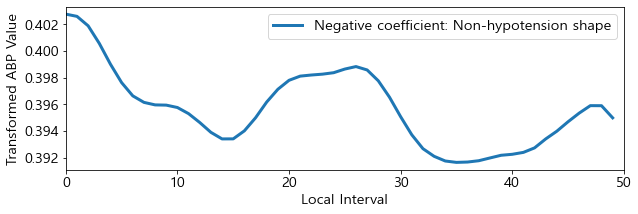

In [43]:
plt.figure(figsize = (10,3))
plt.xlim(0,FrameSize)
plt.plot(GenVecp[pValShapIDX][1], label = 'Negative coefficient: Non-hypotension shape', lw=3)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Local Interval', fontsize='x-large')
plt.ylabel('Transformed ABP Value', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

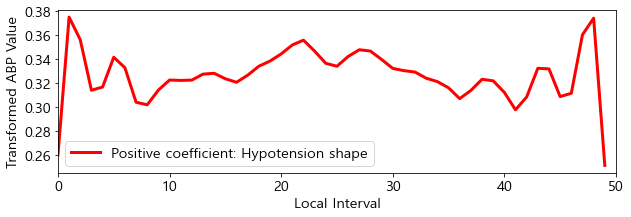

In [44]:
plt.figure(figsize = (10,3))
plt.xlim(0,FrameSize)
plt.plot(GenVecp[pValShapIDX][0], label = 'Positive coefficient: Hypotension shape', color='red', lw=3)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Local Interval', fontsize='x-large')
plt.ylabel('Transformed ABP Value', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

## Ablation Model 2

### Load model with weights

In [4]:
class DoGenVec(tf.keras.layers.Layer):
    
    def __init__(self, OutDimes):
        super(DoGenVec, self).__init__()
        self.Shapelet1Size = OutDimes[0]
        self.WinSize = OutDimes[1]
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'Shapelet1Size': self.Shapelet1Size,
            'WinSize': self.WinSize})
        return config
    
    def build(self, input_shape):
        self.GenVec = self.add_weight("GenVec", shape=[self.Shapelet1Size, self.WinSize], initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
    
    def call(self, input):
        input = K.sum(input) * 0 + 1 # Weight matrix만 return 해주기 위해 이전 input tensor 값을 스칼라 1로 변경 후 weight matrix와 곱함, weight matrix만 return 할 경우 극심한 warning message...
        return (input*self.GenVec)

In [30]:
Shapelet1Size = 30
PaddSideForSim = 12
FrameSize = 50
AttSize = 5

InputVec = Input(shape=(9000), name='Input')

### Replaced : A. Discrete wavelet transform layers ###
FC1 = Conv1D(filters= 1,kernel_size= 20, strides=1, activation='softplus',padding="valid")(InputVec[:,:,None])
FC1 = MaxPooling1D(pool_size=2,strides=2)(FC1)
FC2 = Conv1D(filters= 1,kernel_size= 20, strides=1, activation='softplus',padding="valid")(FC1)
FC2 = MaxPooling1D(pool_size=2,strides=2)(FC2)
FC3 = Conv1D(filters= 1,kernel_size= 20, strides=1, activation='softplus',padding="valid")(FC2)
FC3 = MaxPooling1D(pool_size=2,strides=2)(FC3)
FC4 = Conv1D(filters= 1,kernel_size= 20, strides=1, activation='softplus',padding="valid")(FC3)
FC4 = MaxPooling1D(pool_size=2,strides=2)(FC4)
LP5_Down = Dense(232, activation='sigmoid')(FC4[:,:,0])

LP5_FeatDim = tf.signal.frame(LP5_Down, FrameSize, 1)


### B. Local shape similarity layers ###
GenVecLayer = DoGenVec([Shapelet1Size, FrameSize])
GenVec = Activation('sigmoid')(GenVecLayer(InputVec)) 

LP5_X_sqare = K.sum(K.square(LP5_FeatDim), axis=2,keepdims=True)
LP5_Y_sqare = K.sum(K.square(GenVec[:]), axis=1)[None,None]
LP5_XY = tf.matmul(LP5_FeatDim, GenVec[:], transpose_b=True)
LP5_Dist = (LP5_X_sqare + LP5_Y_sqare - 2*LP5_XY) 
LP5_Dist_sqrt = K.sqrt(LP5_Dist+K.epsilon())


### D. Regresion layers ###
Features_W = K.exp(-LP5_Dist_sqrt) 
Features = K.max(Features_W, axis=1) 
BinOut = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=0),name='BinOut')(Dropout(0.0)(Features))

BinModel = Model(InputVec, BinOut)


### Add cluster loss ###
ClLoss = K.mean(K.min(LP5_Dist, axis=1))
BinModel.add_loss(ClLoss)
BinModel.add_metric(ClLoss, name='ClLoss')

lrate = 0.0005
decay = 1e-6
adam = tf.keras.optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=decay)
BinModel.compile(loss='binary_crossentropy', optimizer='adam',  metrics={'BinOut':['binary_crossentropy','AUC']}, ) #'binary_crossentropy' 
BinModel.load_weights('Ablation2_61_0.34989_0.92420_0.01652_0.38448_0.90570_0.01731.hdf5')

### Table 2.a Prediction Performance

In [7]:
# Internal Validation AUC
from sklearn import metrics
pred = Model(InputVec, BinOut).predict(ValInp[:, 9000:], batch_size=1000, verbose=1)
fprIV, tprIV, thresholdsIV = metrics.roc_curve(ValOut[:], pred, pos_label=1)
metrics.auc(fprIV, tprIV)

60/60 [==============================] - 4s 16ms/step


0.9165300345792955

In [8]:
# External Validation AUC
from sklearn import metrics
pred = Model(InputVec, BinOut).predict(ExternalInp[:, 9000:], batch_size=1000, verbose=1)
fprEV, tprEV, thresholdsEV = metrics.roc_curve(ExternalOut[:], pred, pos_label=1)
metrics.auc(fprEV, tprEV)

60/60 [==============================] - 1s 13ms/step


0.9057057346095759

#### Table 3 Coefficient Values from the Logit Layer

Coefficients by gradient descent method

In [9]:
# extract logistic regression layer from model
Coef = BinModel.get_layer('BinOut').get_weights()[0]

Coefficients by Newton-Raphson method

In [10]:
# extract similarity values (x) for logistic regression
tmpMo = Model(InputVec,Features)
FeaturesPred = tmpMo.predict(ValInp[:, 9000:], batch_size=1000, verbose=1) 

60/60 [==============================] - 1s 16ms/step


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[28, 29]
Num of Features to Keep :  2


<AxesSubplot:>

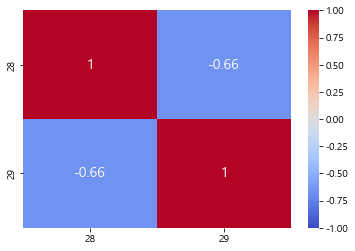

In [11]:
### Filter by correlation ###

# Create correlation matrix
FeaturesPred = pd.DataFrame(FeaturesPred)
FeaturesPred['Hypo'] = ValOut
FeaturesCorr = FeaturesPred.corr()
corr_matrix = FeaturesCorr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_keep = [x for x in list(range(Shapelet1Size)) if x not in to_drop]

print(to_drop) 
print(to_keep) 
print('Num of Features to Keep : ', len(to_keep))
# Drop highly correlated features 
FeaturesPred_bycorr = corr_matrix[to_keep]

sns.heatmap(data = FeaturesCorr.loc[to_keep,to_keep], annot=True, annot_kws={"fontsize":14}, cmap='coolwarm', vmin=-1, vmax=1)

In [12]:
### Logistic regression: X = similarity vlaues, y = hypotension label ###

# DataSet Preparation
X = np.array(FeaturesPred.copy().iloc[:,list(FeaturesPred_bycorr.columns)])
X = sm.add_constant(X)
y = ValOut.copy()

# Fit Logit Model
LogitModel = sm.Logit(y, X)
result = LogitModel.fit()

Optimization terminated successfully.
         Current function value: 0.360302
         Iterations 7


In [13]:
### Filter by p-value ###

StatResult = pd.DataFrame(np.array([np.array(FeaturesPred_bycorr.columns), 
                                    np.round(result.params[1:], 4), 
                                    np.round(result.pvalues, 4)[1:]]).transpose(), 
                          columns=['Feature_ID', 'NR-method', 'pVal'])
StatResult.insert(1, 'GD-method', np.round(Coef[to_keep],4))
pValSig = StatResult.sort_values('pVal').query('pVal <= 0.1')
pValShapIDX = list(pValSig.Feature_ID.astype('int32').values)
pValSig

,Feature_ID,GD-method,NR-method,pVal
0,28,-1.5114,-24.1641,0.0
1,29,1.3149,15.1472,0.0


### Table 4 Confusion Matrix of Maximum Similarity with the Representative Shapes

In [14]:
# extract GenVec layer to obtain representative ABP trends
tmpMo = Model(InputVec, GenVec)
GenVecp = tmpMo.predict(ValInp[0:1, 9000:])
GenVecp.shape

(30, 50)

In [15]:
# extract LP5_Dist_sqrt to compute similarity with representative ABP trends
tmpMo = Model(InputVec,LP5_Dist_sqrt)
LP5Dist = tmpMo.predict(ValInp[:, 9000:], batch_size=1000, verbose=1)  # computing distance
LP5Sim = K.exp(-LP5Dist)  # computing similarity
LP5Sim.shape

60/60 [==============================] - 2s 27ms/step


TensorShape([60000, 183, 30])

In [16]:
### Count the number of samples with maximum similarity to each shape ###

FrequentShap = []
FrequentShapH = [] # Actual hypotension
FrequentShapNH = [] # Actual non-hypotension

for i in range(LP5Sim.shape[0]):
    pValShap = np.array([LP5Sim[i][:,shapIDX] for shapIDX in pValShapIDX])
    FrequentShap.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
    if ValOut[i] == 1:
        FrequentShapH.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
    else:
        FrequentShapNH.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
             
FrequentShapH = np.bincount(np.array(FrequentShapH), minlength=len(pValShapIDX))
FreqGenVecH = GenVecp[pValShapIDX]
FrequentShapNH = np.bincount(np.array(FrequentShapNH), minlength=len(pValShapIDX))
FreqGenVecNH = GenVecp[pValShapIDX]

print("Number of max similiarity with each shape for hypotension samples: ", FrequentShapH)
print("Number of max similiarity with each shape for non-hypotension samples: ", FrequentShapNH)

FreqCounts = pd.DataFrame([FrequentShapH, FrequentShapNH], index=['Hypo', 'NonHypo'], columns=pValShapIDX)
FreqCounts

Number of max similiarity with each shape for hypotension samples:  [27189     0]
Number of max similiarity with each shape for non-hypotension samples:  [32811     0]


,28,29
Hypo,27189,0
NonHypo,32811,0


In [18]:
### Compute confusion matrix for each shape ###

# get predicted values
ValPred = Model(InputVec, BinOut).predict(ValInp[:, 9000:], batch_size=1000, verbose=1)
ValPred = np.where(np.reshape(ValPred, -1)>0.5, 1, 0)
SimShap = np.vstack([np.array(FrequentShap), np.array(ValOut), np.array(ValPred)]) # axis 1 = True , 2 = Pred

# confusion matrix
from sklearn.metrics import confusion_matrix
SimShap_i = SimShap.transpose()[np.where(SimShap[0]==0)[0]][:,1:]
cf = confusion_matrix(SimShap_i[:,0], SimShap_i[:,1])
cf = pd.DataFrame(cf, columns = ['Predicted as non-hypotension', 'Predicted as hypotension'], index = ['Actual non-hypotension', 'Actual hypotension'])
print('\n')
print('ShapeID : ', pValShapIDX[i])
print(cf)

60/60 [==============================] - 1s 16ms/step


ShapeID :  29
                        Predicted as non-hypotension  Predicted as hypotension
Actual non-hypotension                         27621                      5190
Actual hypotension                              3682                     23507


### Fig. 3c Representative shapes of local ABP trends

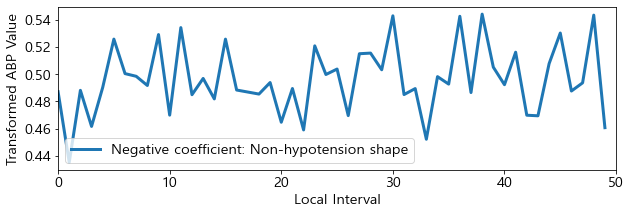

In [24]:
plt.figure(figsize = (10,3))
plt.xlim(0,FrameSize)
plt.plot(GenVecp[pValShapIDX][1], label = 'Negative coefficient: Non-hypotension shape', lw=3)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Local Interval', fontsize='x-large')
plt.ylabel('Transformed ABP Value', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

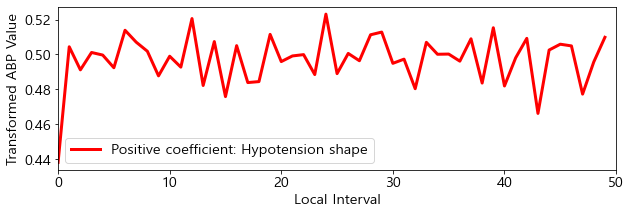

In [25]:
plt.figure(figsize = (10,3))
plt.xlim(0,FrameSize)
plt.plot(GenVecp[pValShapIDX][0], label = 'Positive coefficient: Hypotension shape', color='red', lw=3)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Local Interval', fontsize='x-large')
plt.ylabel('Transformed ABP Value', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()